In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples in the dataset
n_samples = 100000

# Generate synthetic data
data = {
    'income': np.random.randint(20000, 120000, n_samples),  # Income between 20k to 120k
    'age': np.random.randint(18, 70, n_samples),  # Age between 18 and 70
    'family_size': np.random.randint(1, 6, n_samples),  # Family size between 1 and 5
    'education_level': np.random.choice(['High School', 'Associate', 'Bachelor', 'Master', 'PhD'], n_samples),
    'employment_status': np.random.choice(['Employed', 'Unemployed', 'Self-Employed'], n_samples),
    'credit_score': np.random.randint(300, 850, n_samples),  # Credit score between 300 and 850
    'welfare_eligibility': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),  # 30% eligible, 70% not eligible
    'fraud': np.random.choice([0, 1], n_samples, p=[0.95, 0.05])  # 5% fraud, 95% non-fraud
}

# Create a DataFrame
df = pd.DataFrame(data)

# Convert categorical variables to numerical using LabelEncoder
le = LabelEncoder()
df['education_level'] = le.fit_transform(df['education_level'])
df['employment_status'] = le.fit_transform(df['employment_status'])

# Print the first few rows to inspect the generated data
print(df.head())
print(f"\nDataset shape: {df.shape}")

# Check class distribution for fraud and welfare eligibility
print("\nFraud Class Distribution (1 = Fraud, 0 = Non-Fraud):")
print(df['fraud'].value_counts())

print("\nWelfare Eligibility Class Distribution (1 = Eligible, 0 = Not Eligible):")
print(df['welfare_eligibility'].value_counts())

# Save the generated dataset
df.to_csv('//content/fraud_welfare_data.csv', index=False)
print("\nDataset saved as 'synfraud_welfare_data.csv'")


   income  age  family_size  education_level  employment_status  credit_score  \
0   35795   18            3                2                  1           807   
1   20860   44            5                0                  2           336   
2   96820   31            4                4                  1           366   
3   74886   58            5                3                  1           799   
4   26265   26            2                2                  2           736   

   welfare_eligibility  fraud  
0                    0      0  
1                    0      0  
2                    0      0  
3                    0      0  
4                    0      0  

Dataset shape: (100000, 8)

Fraud Class Distribution (1 = Fraud, 0 = Non-Fraud):
fraud
0    94949
1     5051
Name: count, dtype: int64

Welfare Eligibility Class Distribution (1 = Eligible, 0 = Not Eligible):
welfare_eligibility
0    69976
1    30024
Name: count, dtype: int64

Dataset saved as 'synfraud_welfare_data.cs

In [ ]:
file_path = '/content/insurance_claims.csv'
df_insurance = pd.read_csv(file_path)

# Check the first few rows
df_insurance.head()


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


Original insurance shape: (1000, 40)
Original welfare shape: (100000, 8)

Merged dataset shape: (1000, 44)


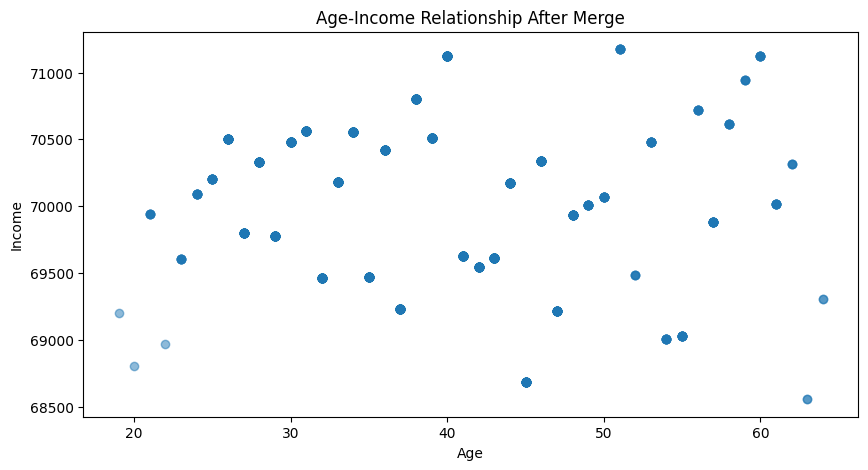

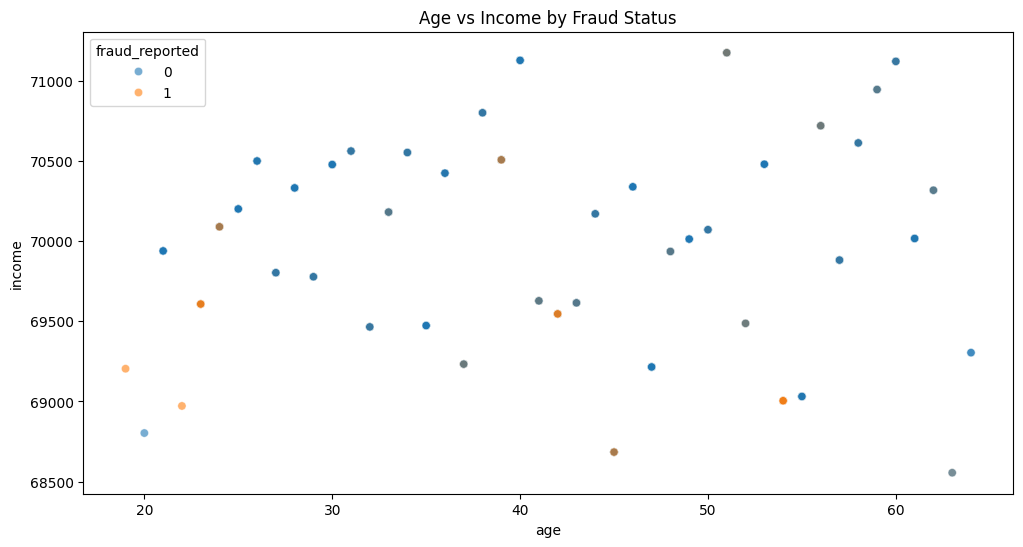

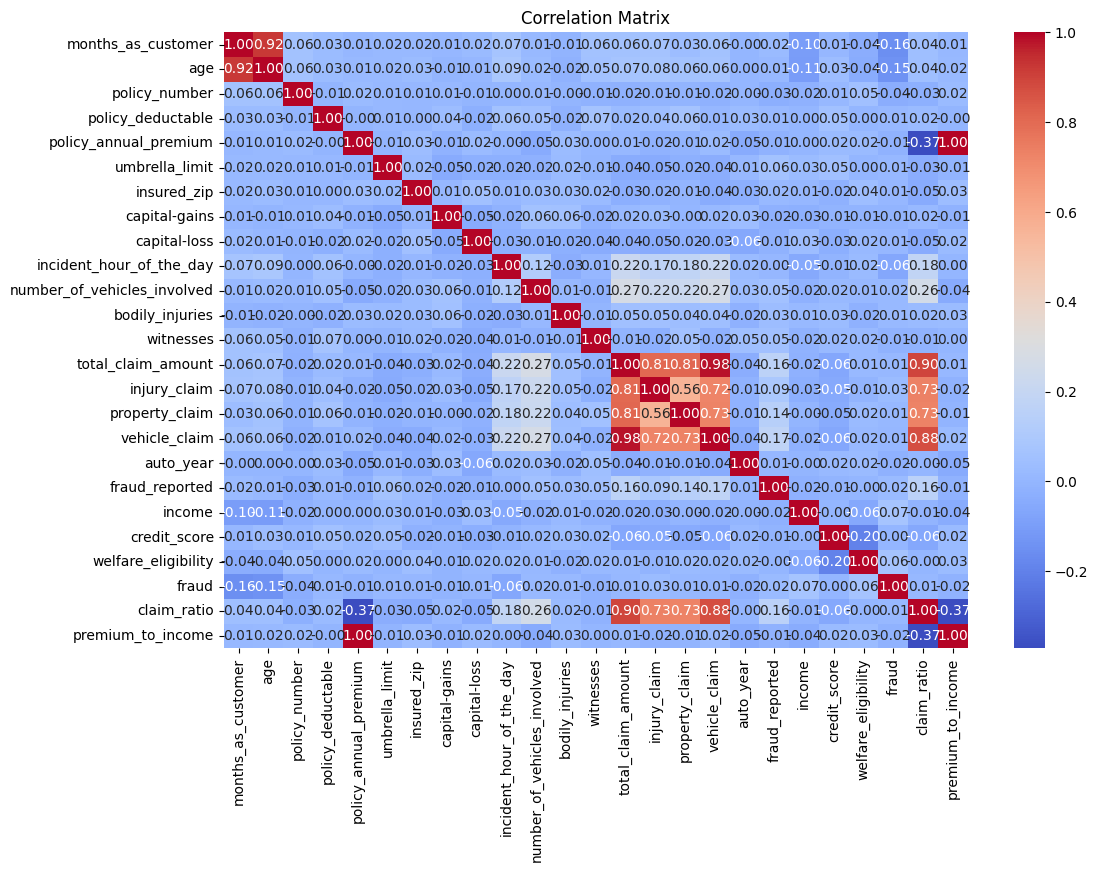

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import shap

df_insurance = pd.read_csv('/content/insurance_claims.csv')
df_fraud_welfare = pd.read_csv('/content/fraud_welfare_data.csv')

print("Original insurance shape:", df_insurance.shape)
print("Original welfare shape:", df_fraud_welfare.shape)

welfare_stats = df_fraud_welfare.groupby('age').agg({
    'income': 'mean',
    'credit_score': 'mean',
    'welfare_eligibility': 'mean',
    'fraud': 'mean'
}).reset_index()

merged_df = pd.merge(
    df_insurance,
    welfare_stats,
    on='age',
    how='left'
)

print("\nMerged dataset shape:", merged_df.shape)

merged_df = merged_df.drop(columns=[col for col in merged_df.columns if '_c39' in col], errors='ignore')

merged_df['authorities_contacted'] = merged_df['authorities_contacted'].fillna('UNKNOWN')

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.scatter(merged_df['age'], merged_df['income'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Age-Income Relationship After Merge')
plt.show()

merged_df['authorities_contacted'] = merged_df['authorities_contacted'].fillna('UNKNOWN')


merged_df['claim_ratio'] = merged_df['total_claim_amount'] / merged_df['policy_annual_premium']
merged_df['premium_to_income'] = merged_df['policy_annual_premium'] / merged_df['income']

merged_df['fraud_reported'] = merged_df['fraud_reported'].map({'Y': 1, 'N': 0})

import seaborn as sns
import matplotlib.pyplot as plt

# Plot relationships
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='age', y='income', hue='fraud_reported', alpha=0.6)
plt.title('Age vs Income by Fraud Status')
plt.show()

# Correlation analysis
numeric_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 4. Save cleaned data
merged_df.to_csv('insurance_with_welfare_stats.csv', index=False)

Loading datasets...

=== Insurance Claims Dataset ===
Shape: (1000, 40)
Columns: ['months_as_customer', 'age', 'policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported', '_c39']

First 5 rows:
   months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       2014-10-17           OH   
1       

<Figure size 1000x600 with 0 Axes>

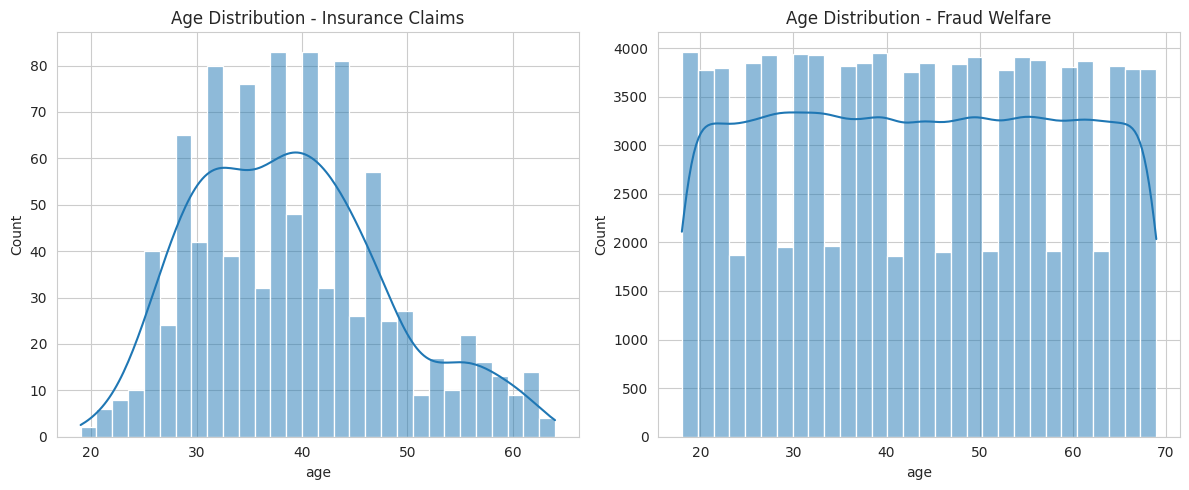


Merging datasets on 'age' column...

=== Merged Dataset ===
Shape: (1930610, 47)
Columns: ['months_as_customer', 'age', 'policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported', '_c39', 'income', 'family_size', 'education_level', 'employment_status', 'credit_score', 'welfare_eligibility', 'fraud']

First 5 rows:
   months_as_customer  age  policy_

<Figure size 1400x600 with 0 Axes>

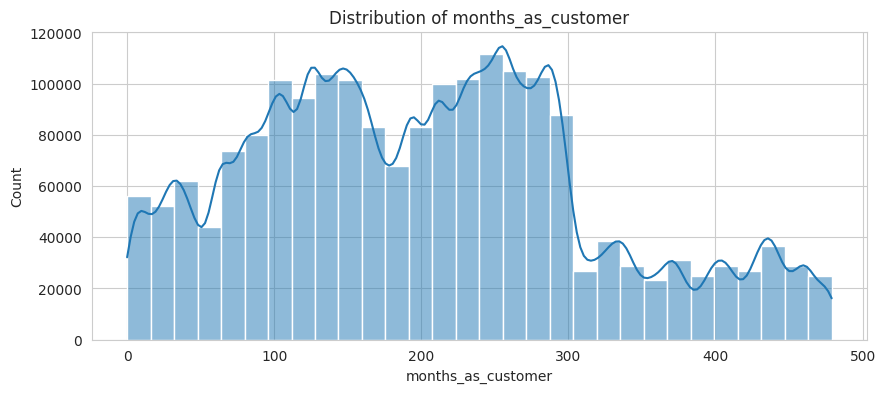

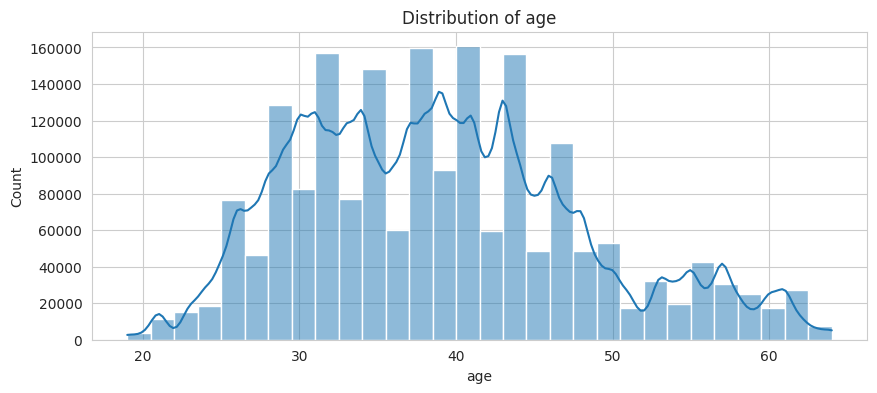

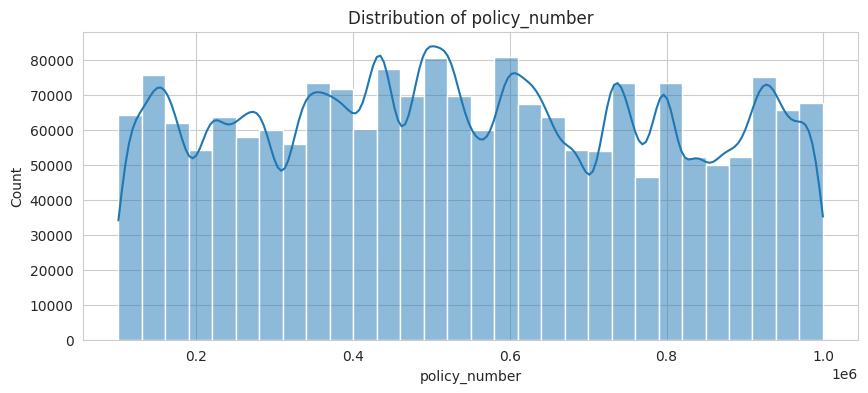

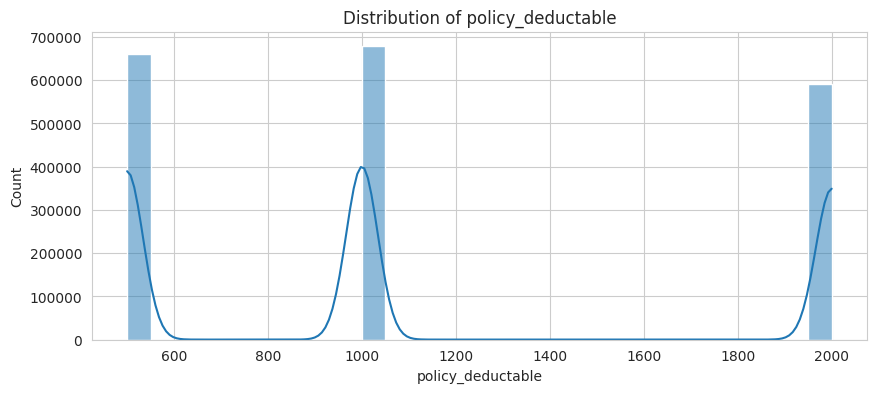


Visualizing categorical features...


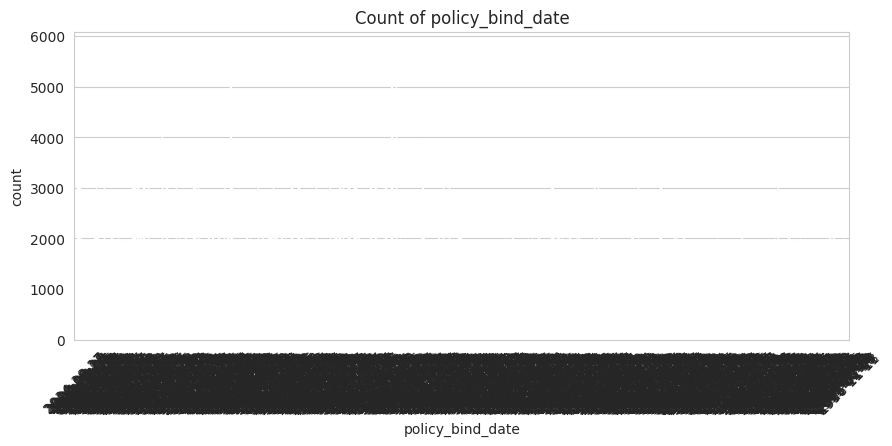

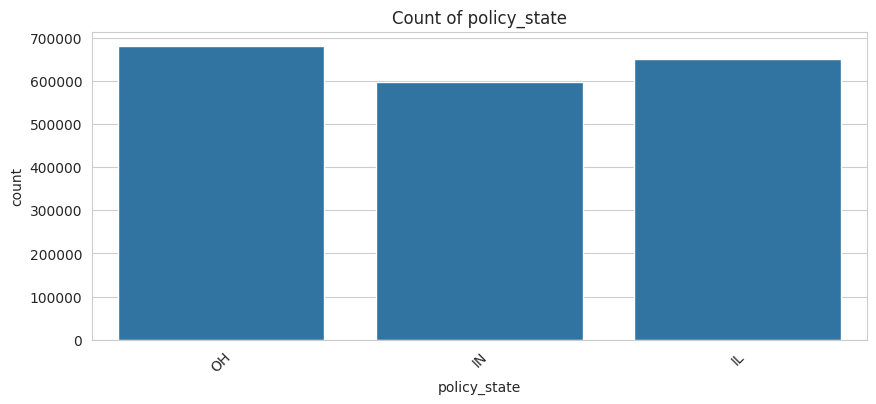

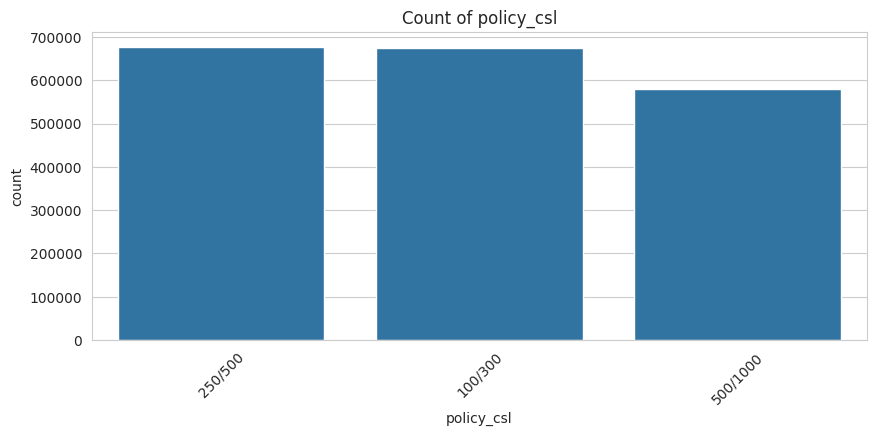


Calculating correlations...


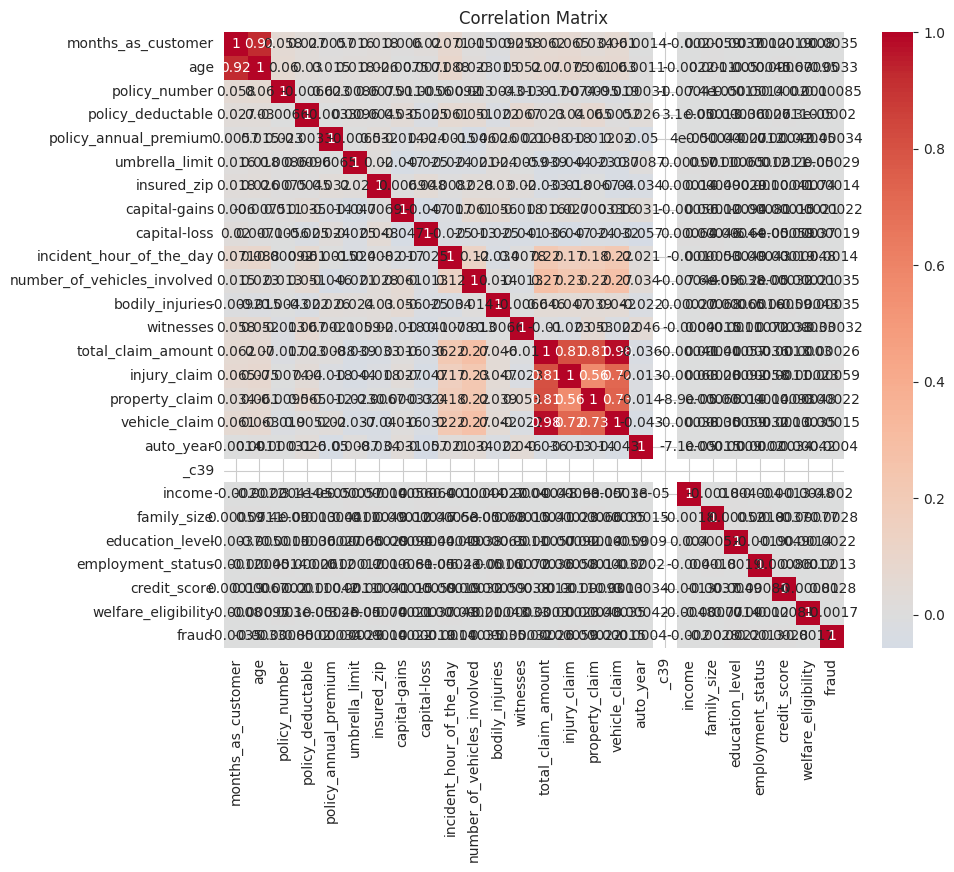


EDA completed!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for visualizations
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Paths to the datasets (update with your actual paths)
insurance_claims_path = '/content/insurance_claims.csv'
fraud_welfare_data_path = '/content/fraud_welfare_data.csv'

# Load the datasets with basic info printing
print("Loading datasets...")
df_insurance = pd.read_csv(insurance_claims_path)
df_fraud_welfare = pd.read_csv(fraud_welfare_data_path)

print("\n=== Insurance Claims Dataset ===")
print(f"Shape: {df_insurance.shape}")
print(f"Columns: {df_insurance.columns.tolist()}")
print("\nFirst 5 rows:")
print(df_insurance.head())

print("\n=== Fraud Welfare Dataset ===")
print(f"Shape: {df_fraud_welfare.shape}")
print(f"Columns: {df_fraud_welfare.columns.tolist()}")
print("\nFirst 5 rows:")
print(df_fraud_welfare.head())

# Basic statistics
print("\nInsurance Claims Description:")
print(df_insurance.describe(include='all'))

print("\nFraud Welfare Description:")
print(df_fraud_welfare.describe(include='all'))

# Visualize distributions before merging
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_insurance['age'], bins=30, kde=True)
plt.title('Age Distribution - Insurance Claims')

plt.subplot(1, 2, 2)
sns.histplot(df_fraud_welfare['age'], bins=30, kde=True)
plt.title('Age Distribution - Fraud Welfare')
plt.tight_layout()
plt.show()

# Merge the datasets on 'age' column
print("\nMerging datasets on 'age' column...")
merged_df = pd.merge(df_insurance, df_fraud_welfare, on='age', how='inner')

# Print merged dataset info
print(f"\n=== Merged Dataset ===")
print(f"Shape: {merged_df.shape}")
print(f"Columns: {merged_df.columns.tolist()}")
print("\nFirst 5 rows:")
print(merged_df.head())

print("\nData Types:")
print(merged_df.dtypes)

print("\nMissing Values:")
print(merged_df.isnull().sum())

# Visualize merged dataset
plt.figure(figsize=(14, 6))

# Numeric features distribution
numeric_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_cols) > 0:
    print("\nVisualizing numeric features...")
    for i, col in enumerate(numeric_cols[:4]):  # Limit to first 4 numeric columns
        plt.figure(figsize=(10, 4))
        sns.histplot(merged_df[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

# Categorical features
categorical_cols = merged_df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print("\nVisualizing categorical features...")
    for i, col in enumerate(categorical_cols[:3]):  # Limit to first 3 categorical columns
        plt.figure(figsize=(10, 4))
        sns.countplot(data=merged_df, x=col)
        plt.title(f'Count of {col}')
        plt.xticks(rotation=45)
        plt.show()

# Correlation matrix for numeric features
if len(numeric_cols) > 1:
    print("\nCalculating correlations...")
    corr_matrix = merged_df[numeric_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()

print("\nEDA completed!")

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. First create all derived features
merged_df['claim_ratio'] = merged_df['total_claim_amount'] / merged_df['policy_annual_premium']
merged_df['premium_to_income'] = merged_df['policy_annual_premium'] / merged_df['income']
merged_df['multiple_vehicles_flag'] = (merged_df['number_of_vehicles_involved'] > 1).astype(int)
merged_df['high_claim_ratio'] = (merged_df['claim_ratio'] > 3).astype(int)

# 2. Define final feature sets
final_fraud_features = [
    'claim_ratio',
    'total_claim_amount',
    'income',
    'credit_score',
    'incident_severity',
    'premium_to_income',
    'police_report_available',
    'employment_status',
    'age',
    'witnesses'
]

final_welfare_features = [
    'income',
    'family_size',
    'credit_score',
    'employment_status',
    'education_level',
    'premium_to_income',
    'age',
    'policy_annual_premium'
]

# 3. Handle missing values if any (example for one column)
if 'police_report_available' in merged_df.columns:
    merged_df['police_report_available'] = merged_df['police_report_available'].fillna('UNKNOWN')

# 4. Create feature matrices
X_fraud = merged_df[final_fraud_features].copy()
X_welfare = merged_df[final_welfare_features].copy()

# 5. Preprocessing pipelines
# Define which features are numeric vs categorical
fraud_numeric = ['claim_ratio', 'total_claim_amount', 'income', 'credit_score',
                 'premium_to_income', 'age', 'witnesses']
fraud_categorical = ['incident_severity', 'police_report_available', 'employment_status']

welfare_numeric = ['income', 'credit_score', 'premium_to_income', 'age', 'policy_annual_premium']
welfare_categorical = ['employment_status', 'education_level']

# Create preprocessors
fraud_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), fraud_numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), fraud_categorical)
    ])

welfare_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), welfare_numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), welfare_categorical)
    ])

# 6. Targets
y_fraud = merged_df['fraud_reported']
y_welfare = merged_df['welfare_eligibility']

print("Fraud detection features ready:", X_fraud.shape)
print("Welfare prediction features ready:", X_welfare.shape)

Fraud detection features ready: (1930610, 10)
Welfare prediction features ready: (1930610, 8)


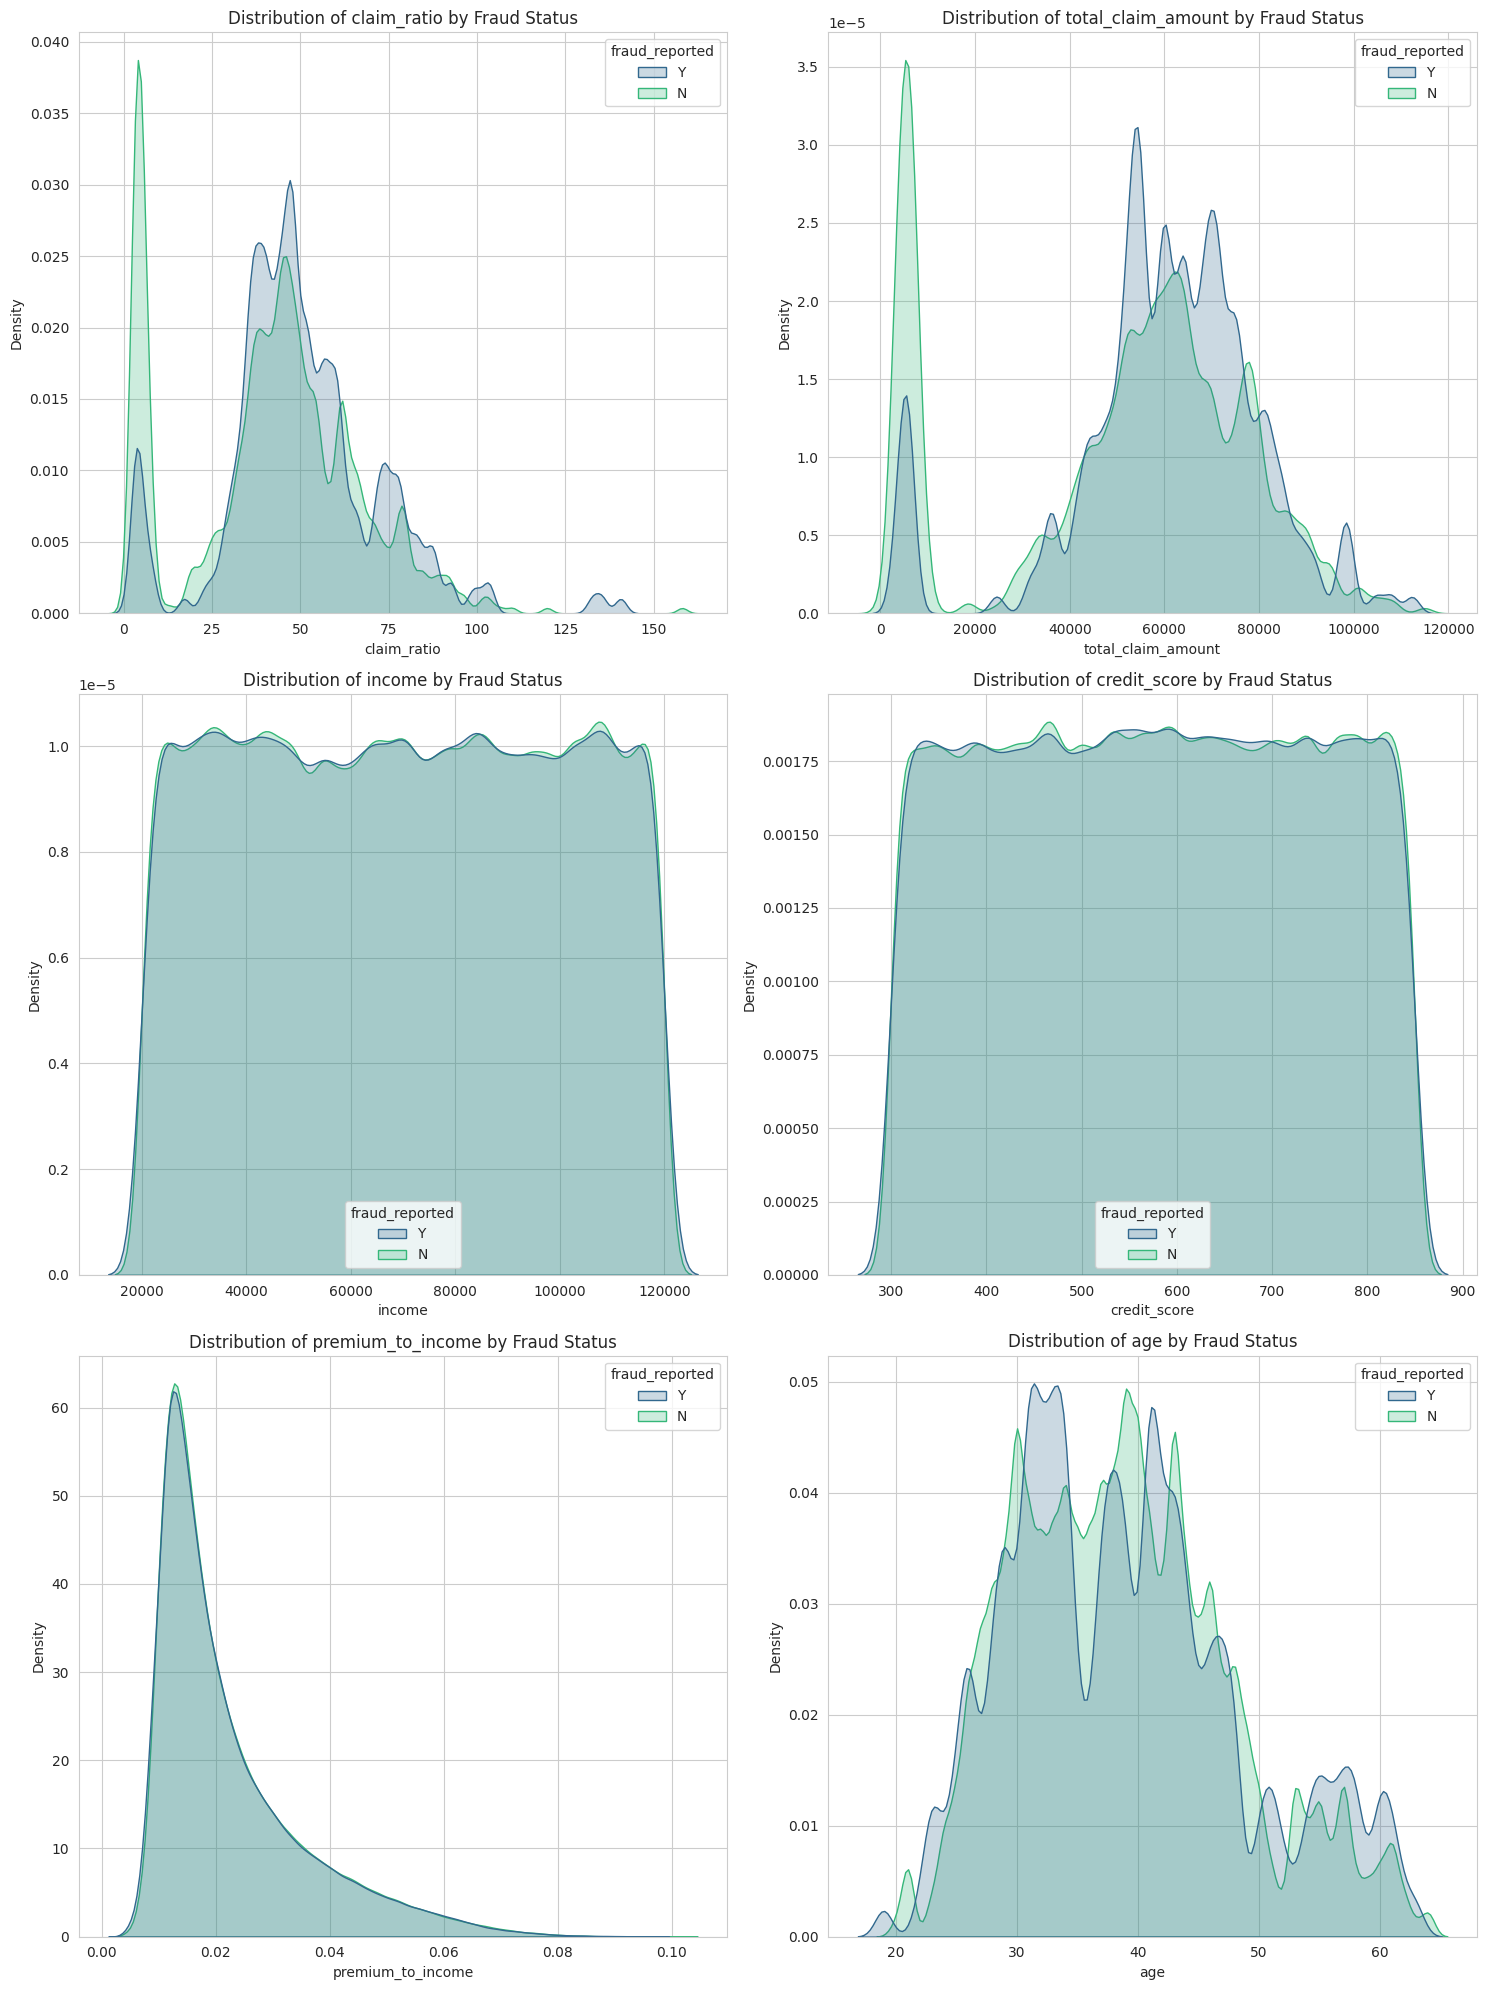

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 20))

#key fraud detection features to visualize
fraud_features_to_plot = [
    'claim_ratio',
    'total_claim_amount',
    'income',
    'credit_score',
    'premium_to_income',
    'age'
]

# Create distribution plots
for i, feature in enumerate(fraud_features_to_plot, 1):
    plt.subplot(3, 2, i)

    # Plot distribution by fraud status
    sns.kdeplot(data=merged_df, x=feature, hue='fraud_reported',
                fill=True, common_norm=False, palette='viridis')

    plt.title(f'Distribution of {feature} by Fraud Status')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

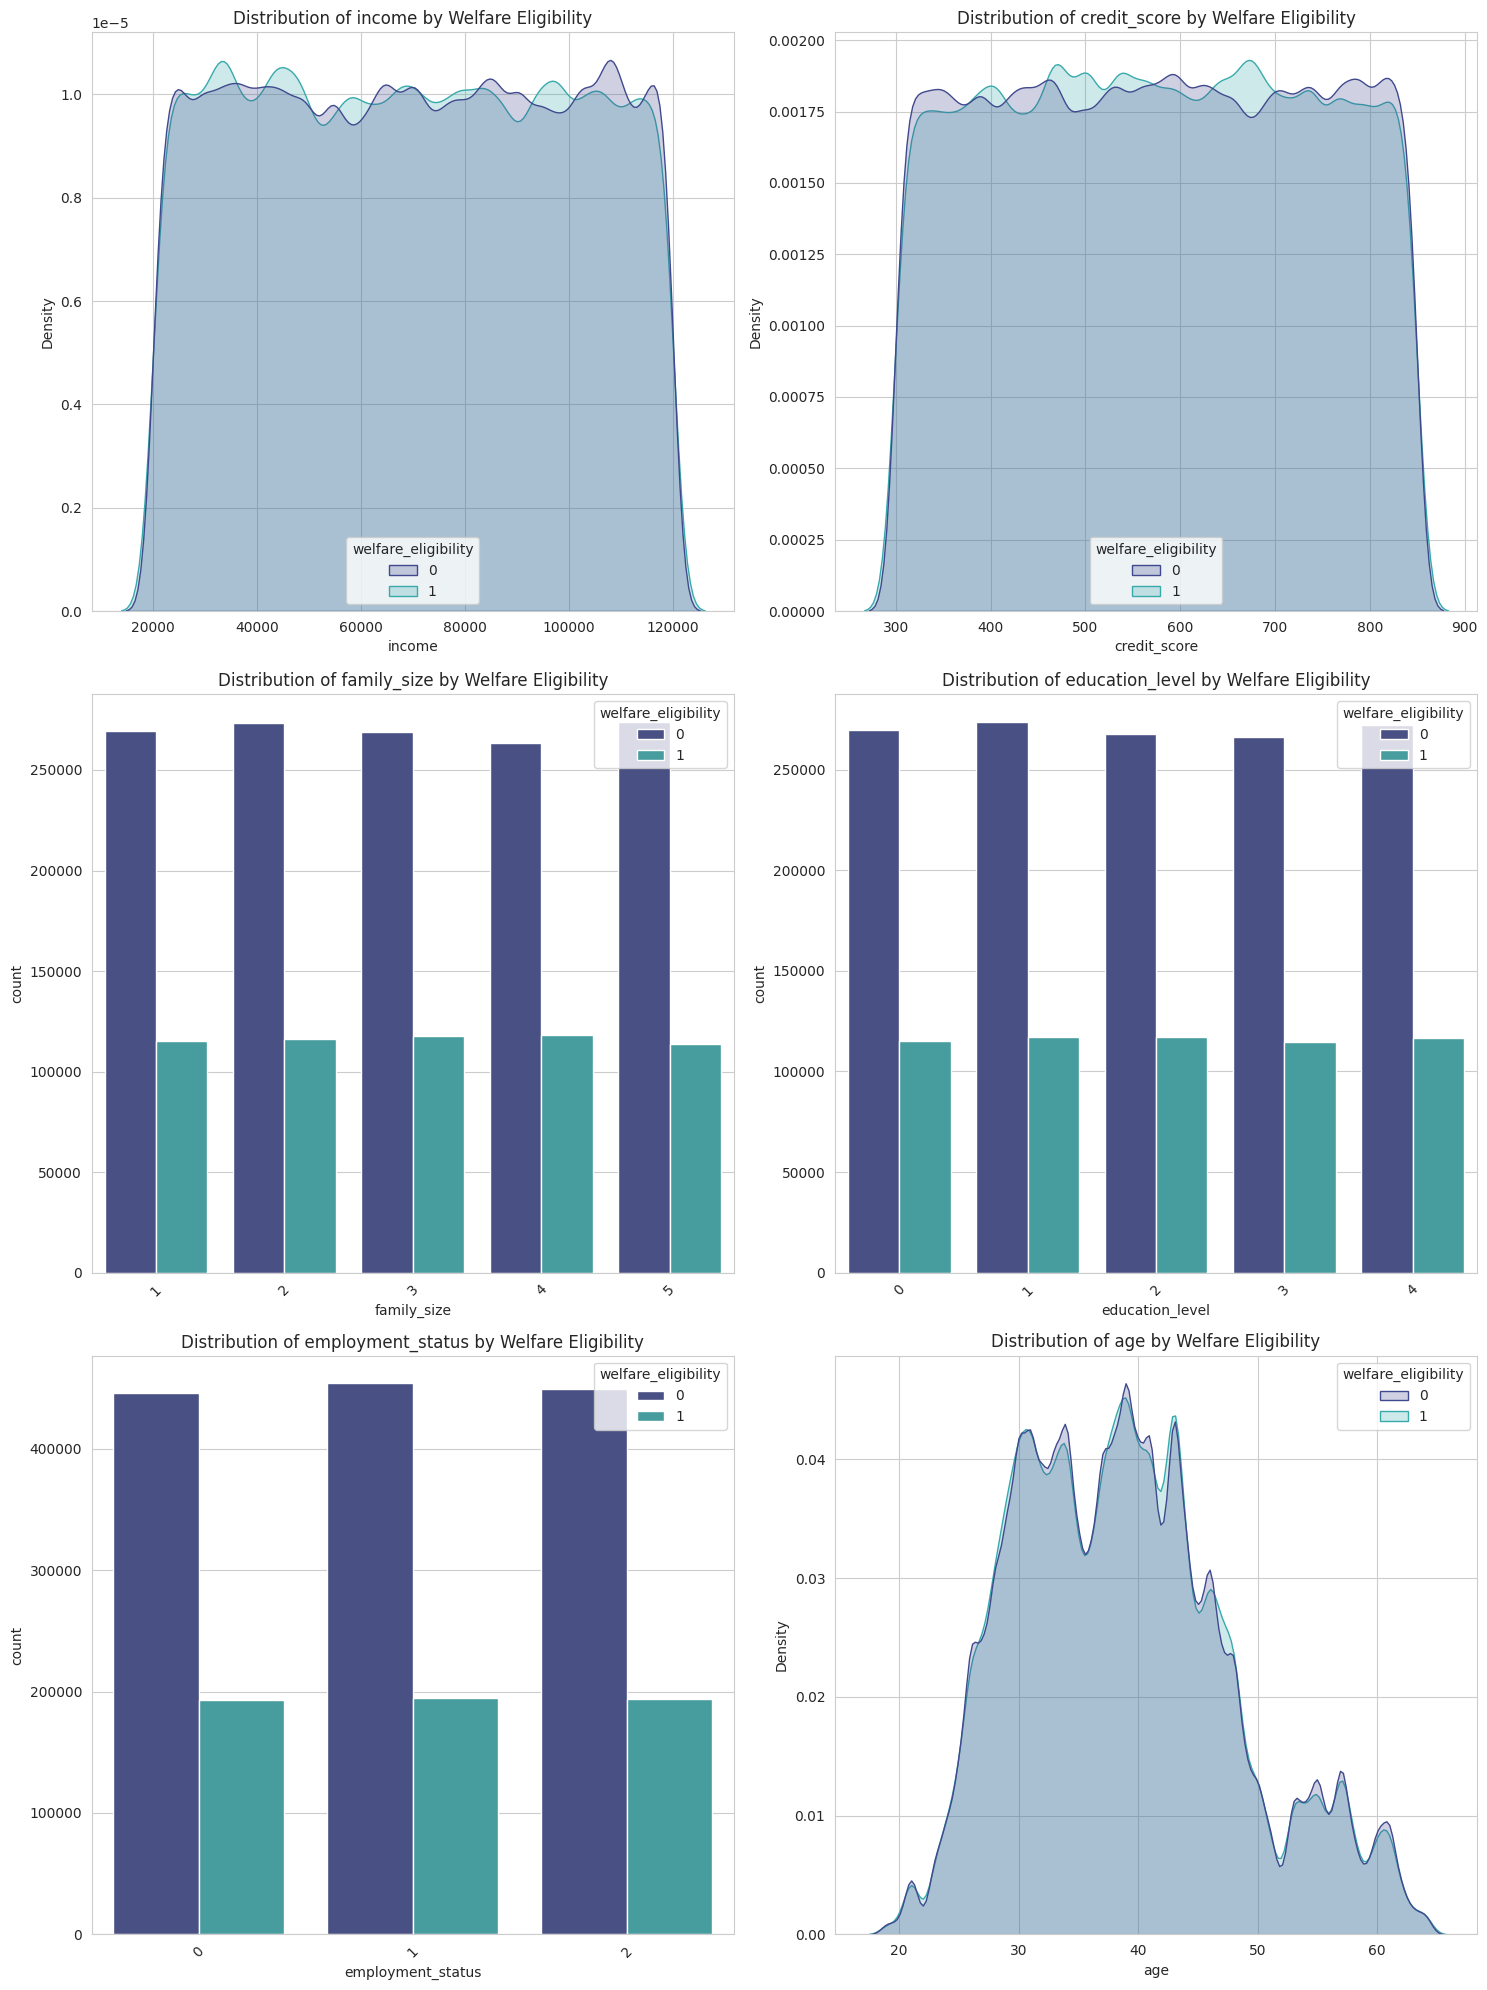

In [ ]:
# Set style
plt.figure(figsize=(15, 20))

# Select key welfare prediction features to visualize
welfare_features_to_plot = [
    'income',
    'credit_score',
    'family_size',
    'education_level',
    'employment_status',
    'age'
]

# Create distribution plots
for i, feature in enumerate(welfare_features_to_plot, 1):
    plt.subplot(3, 2, i)

    if merged_df[feature].nunique() < 10:  # For categorical/discrete features
        sns.countplot(data=merged_df, x=feature, hue='welfare_eligibility',
                     palette='mako')
        plt.xticks(rotation=45)
    else:  # For continuous features
        sns.kdeplot(data=merged_df, x=feature, hue='welfare_eligibility',
                   fill=True, common_norm=False, palette='mako')

    plt.title(f'Distribution of {feature} by Welfare Eligibility')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. Data Preparation
# Convert target variables
merged_df['fraud_reported'] = merged_df['fraud_reported'].map({'Y': 1, 'N': 0})

# Encode categorical features
label_encoders = {}
for col in ['incident_severity', 'police_report_available', 'employment_status']:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))
    label_encoders[col] = le

# 2. Feature Sets (using previously defined features)
X_fraud = merged_df[final_fraud_features]
X_welfare = merged_df[final_welfare_features]

y_fraud = merged_df['fraud_reported']
y_welfare = merged_df['welfare_eligibility']

# 3. Train-Test Split
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.3, random_state=42, stratify=y_fraud)

X_welfare_train, X_welfare_test, y_welfare_train, y_welfare_test = train_test_split(
    X_welfare, y_welfare, test_size=0.3, random_state=42, stratify=y_welfare)

# 4. Fraud Detection Model
fraud_dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

fraud_dt.fit(X_fraud_train, y_fraud_train)

# 5. Welfare Prediction Model
welfare_dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

welfare_dt.fit(X_welfare_train, y_welfare_train)


DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)


=== Fraud Detection Evaluation ===
              precision    recall  f1-score   support

           0       0.92      0.82      0.86    436234
           1       0.58      0.78      0.66    142949

    accuracy                           0.81    579183
   macro avg       0.75      0.80      0.76    579183
weighted avg       0.83      0.81      0.81    579183

AUC-ROC: 0.849


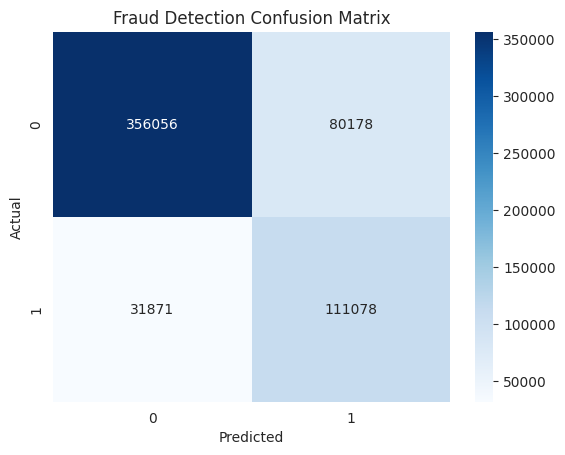


=== Welfare Prediction Evaluation ===
              precision    recall  f1-score   support

           0       0.70      1.00      0.82    404830
           1       0.83      0.00      0.00    174353

    accuracy                           0.70    579183
   macro avg       0.77      0.50      0.41    579183
weighted avg       0.74      0.70      0.58    579183

AUC-ROC: 0.521


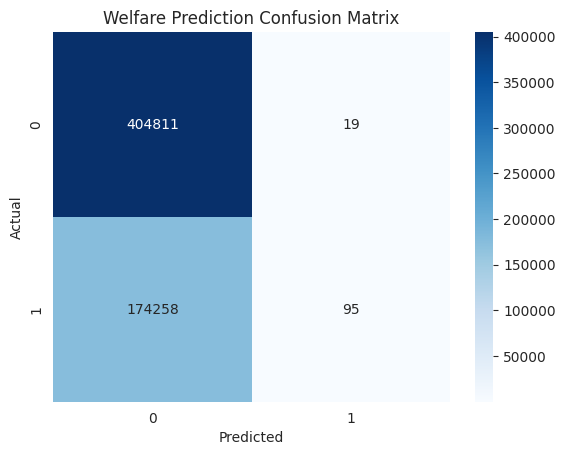

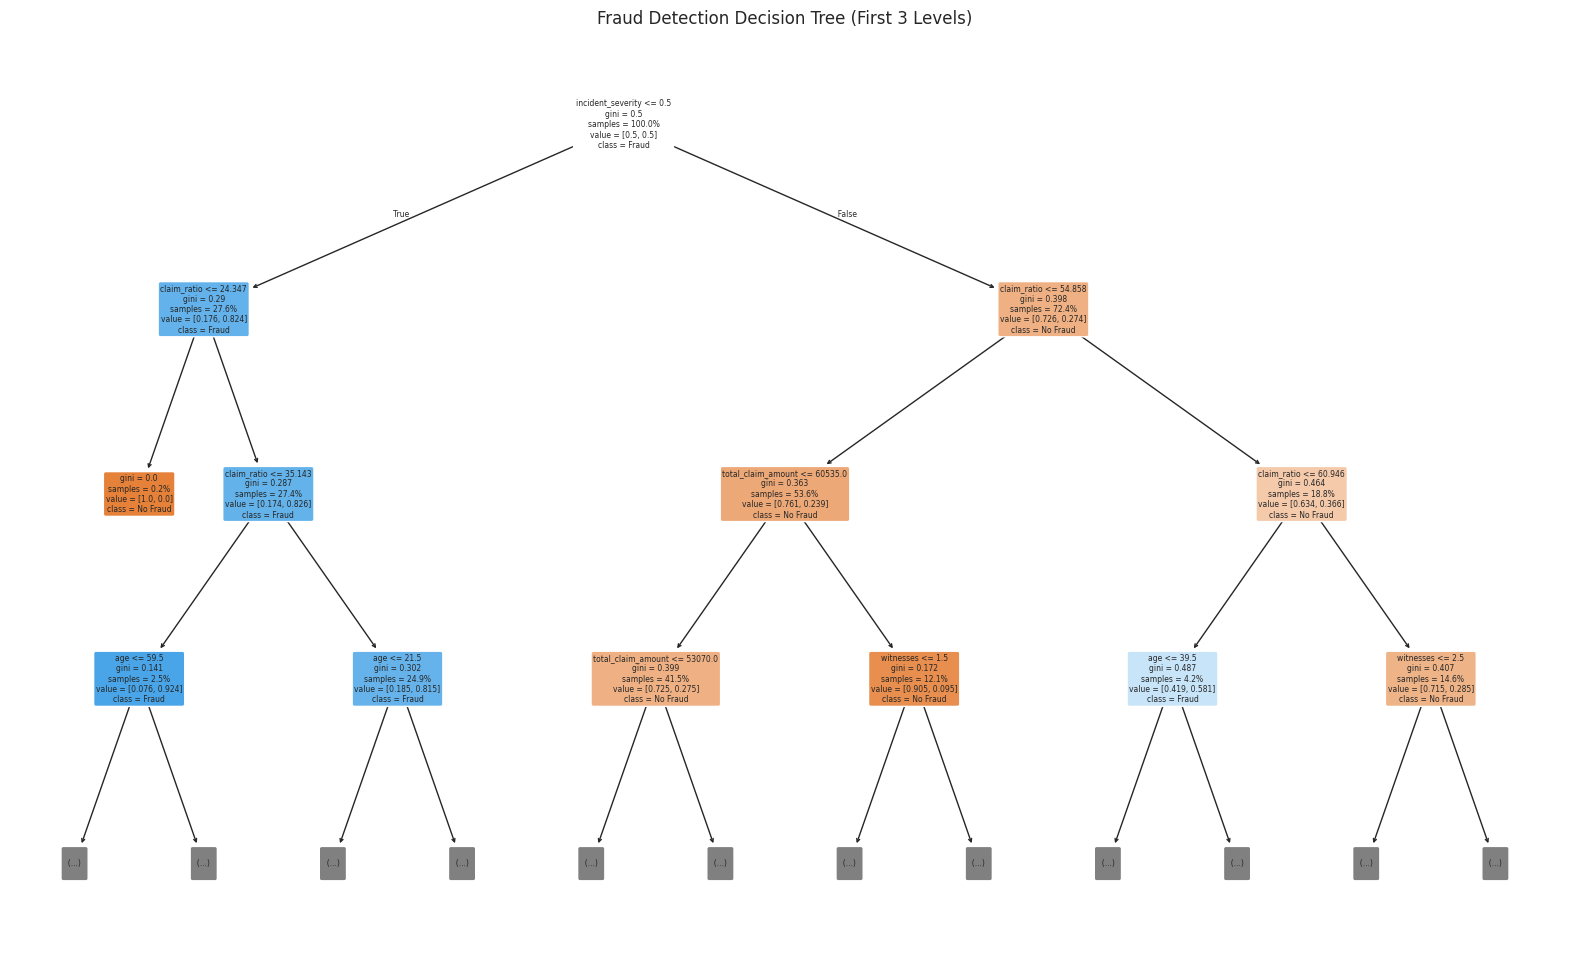

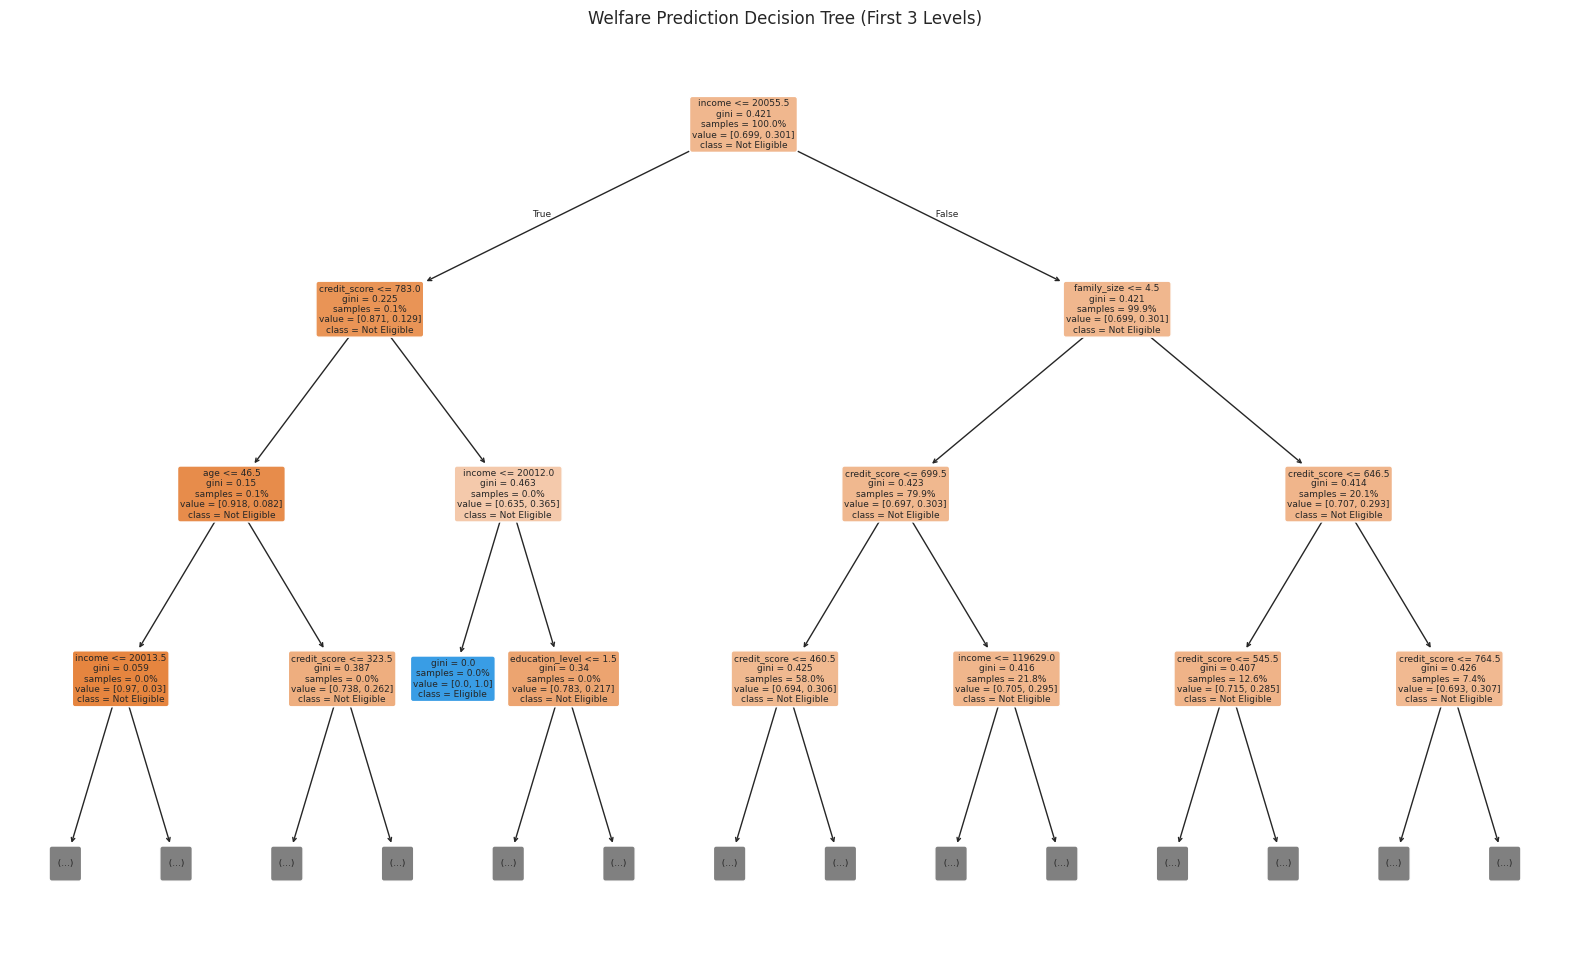

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {model_name} Evaluation ===")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return y_proba

# Evaluate both models
fraud_probs = evaluate_model(fraud_dt, X_fraud_test, y_fraud_test, "Fraud Detection")
welfare_probs = evaluate_model(welfare_dt, X_welfare_test, y_welfare_test, "Welfare Prediction")

# 7. Visualize Decision Trees
plt.figure(figsize=(20, 12))
plot_tree(fraud_dt,
          feature_names=X_fraud.columns,
          class_names=['No Fraud', 'Fraud'],
          filled=True,
          rounded=True,
          proportion=True,
          max_depth=3)  # Show first 3 levels for clarity
plt.title("Fraud Detection Decision Tree (First 3 Levels)")
plt.show()

plt.figure(figsize=(20, 12))
plot_tree(welfare_dt,
          feature_names=X_welfare.columns,
          class_names=['Not Eligible', 'Eligible'],
          filled=True,
          rounded=True,
          proportion=True,
          max_depth=3)
plt.title("Welfare Prediction Decision Tree (First 3 Levels)")
plt.show()


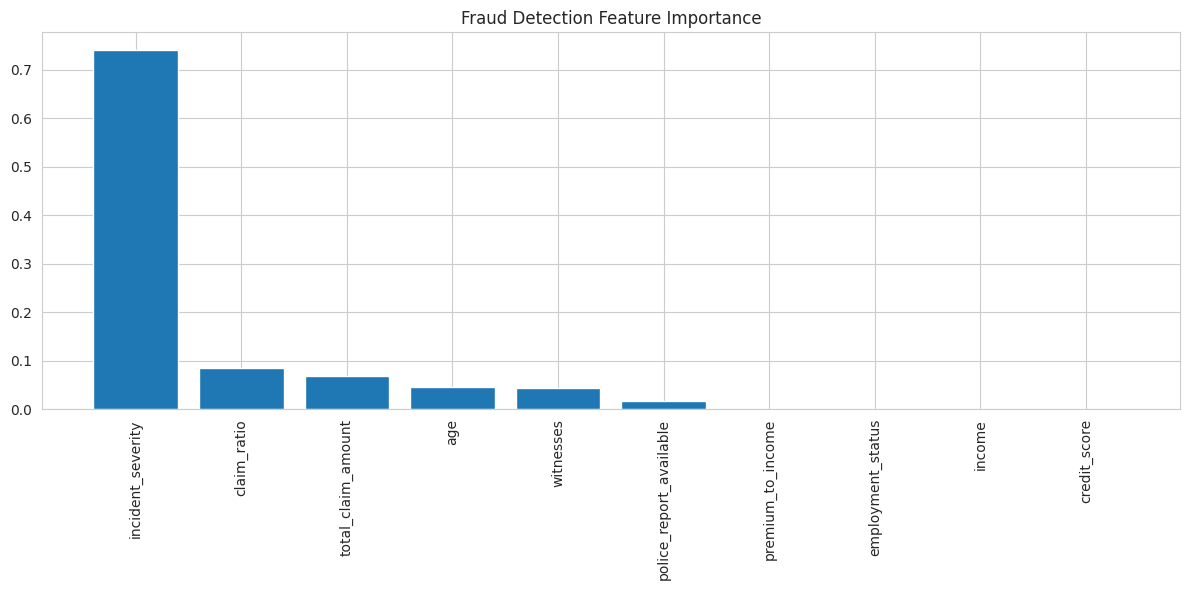

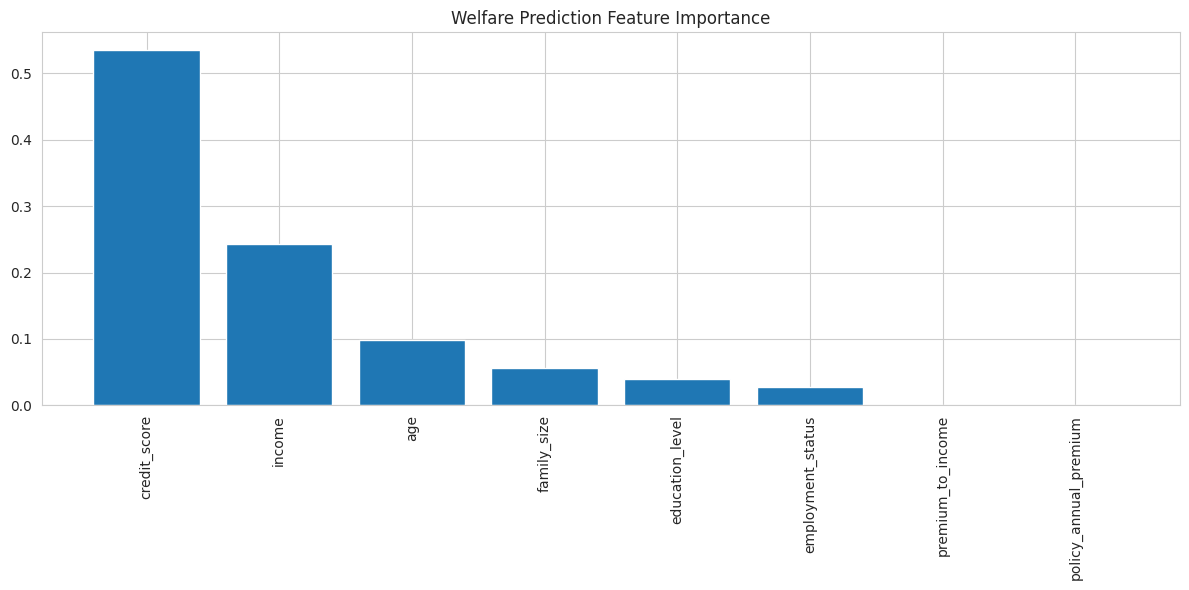

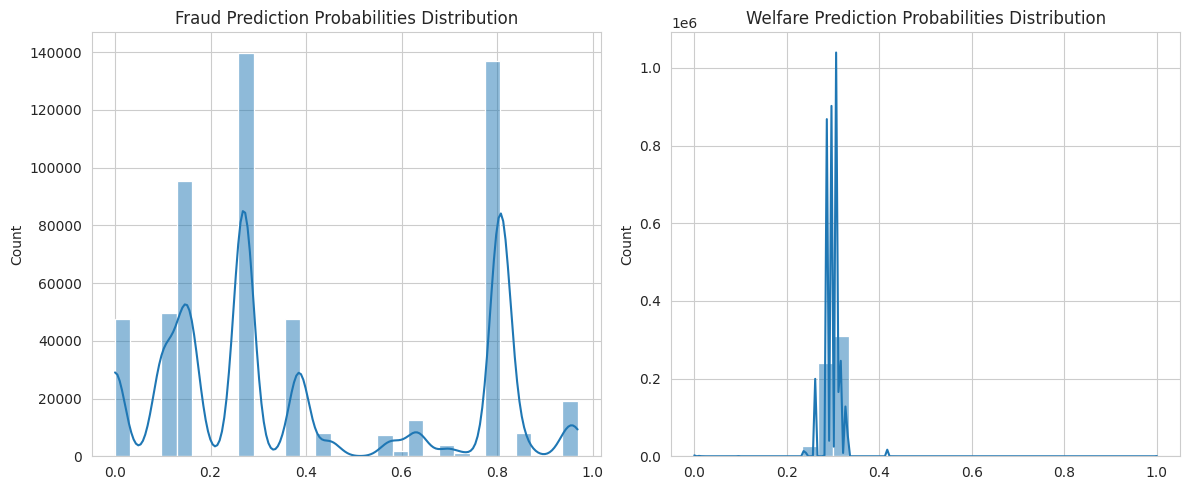

In [ ]:

# 8. Feature Importance Analysis
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

plot_feature_importance(fraud_dt, X_fraud.columns, "Fraud Detection Feature Importance")
plot_feature_importance(welfare_dt, X_welfare.columns, "Welfare Prediction Feature Importance")

# 9. Probability Distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(fraud_probs, bins=30, kde=True)
plt.title('Fraud Prediction Probabilities Distribution')

plt.subplot(1, 2, 2)
sns.histplot(welfare_probs, bins=30, kde=True)
plt.title('Welfare Prediction Probabilities Distribution')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import shap
from tqdm import tqdm


def shap_analysis(model, X_train, X_test, model_name, sample_size=500):
    print(f"\nCalculating SHAP values for {model_name}...")

    # Initialize explainer
    explainer = shap.TreeExplainer(model)

    # Sample test data
    sample_idx = np.random.choice(len(X_test), min(sample_size, len(X_test)), replace=False)
    X_sample = X_test.iloc[sample_idx]

    # Calculate SHAP values in batches
    shap_values = []
    batch_size = 50
    for i in tqdm(range(0, len(X_sample), batch_size)):
        batch = X_sample.iloc[i:i+batch_size]
        shap_values_batch = explainer.shap_values(batch)
        if isinstance(shap_values_batch, list):  # For binary classification
            shap_values.append(shap_values_batch[1])  # Take class 1 (fraud/eligible)
        else:
            shap_values.append(shap_values_batch)

    shap_values = np.concatenate(shap_values)


print("\nSHAP analysis complete!")


SHAP analysis complete!
